In [58]:
### Si données locales
u.user <- read.csv(file='u.user.csv', sep='|', header=T)
u.item <- read.csv(file='u.item.csv', sep='|', header=T)
u.data <- read.csv(file='u.data.csv', sep='|', header=T)
library(Matrix)
m.sparse <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m.sparse) <- paste('u', 1:nrow(m.sparse), sep='')
colnames(m.sparse) <- paste('i', 1:ncol(m.sparse), sep='')
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)

m <- as.matrix(m.sparse)                # transforme en matrice ordinaire
m.na <- m
m.na[m.na==0] <- NA
mae.rmse <- function(m, m.hat) {
    return(list(mae=mean(abs(m - m.hat), na.rm=T), rmse=sqrt(mean((m - m.hat)^2, na.rm=T))))
}
new.m.mae.rmse <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)
mae.rmse(m.svd2, m)
    }

In [59]:
new.m.cv <- function(dimRedu){
# matrice diagonale pour réduire les matrices originales
m.d2 <- diag(c(m.svd$d[1:dimRedu],rep(0,length(m.svd$d)-dimRedu)))
# nouvelle matrice basée sur les deux premières dimensions uniquement
m.svd2 <- round((m.svd$u %*% m.d2 %*% t(m.svd$v)),2)+r.means
mae(m.svd2[i.test.b], m.na[i.test.b])
    }


In [60]:
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
fold.size <- round(length(i.hasard) / 5)
i.false <- rep(FALSE, length(m))
to.plot <- c()
set.seed(1)
cv.b <- c()
ptm <- proc.time()
for (i in seq_len(5)){
fold.number <- i

## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false
## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE
## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.train <- m
m.train[i.test.b] <- 0                # on enlève les données de test pour l'entraînement
m.train.na <- m.train
m.train.na[m.train==0]<-NA
    
u.mean <- matrix(rowMeans(m.train.na, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.train.na, na.rm=T), nrow(m), ncol(m), byrow=T)
m.expect <- ((u.mean + item.mean)/2)
m.train.na[m.train==0] <-m.expect[m.train==0]
r.means <- rowMeans(m.train.na,na.rm=T)
m.train.na[!is.finite(m.train.na)]<- r.means
r.means <- rowMeans(m.train.na,na.rm=T)
cv.b <- c(cv.b,mae(m.train.na[i.test.b], m.na[i.test.b]))
m.train.na <- m.train.na-r.means
m.svd <- svd(m.train.na)

to.plot<-rbind(to.plot,unlist(lapply(seq(22), new.m.cv)))
    }
(proc.time()-ptm)/5


   user  system elapsed 
 25.594   0.296  25.908 

In [61]:
to.plot<-apply(to.plot,2,unlist)

In [62]:
sdev <- apply(to.plot,2,sd) 
avg <- colMeans(to.plot)
avg
x <- 1:length(avg)

[1] 0.7803628 0.7692556 0.7645615 0.7633096 0.7615050 0.7598421 0.7576222
 [8] 0.7568571 0.7565948 0.7561171 0.7562216 0.7563183 0.7563242 0.7564354
[15] 0.7565878 0.7569238 0.7568410 0.7567171 0.7570259 0.7571912 0.7575573
[22] 0.7578110

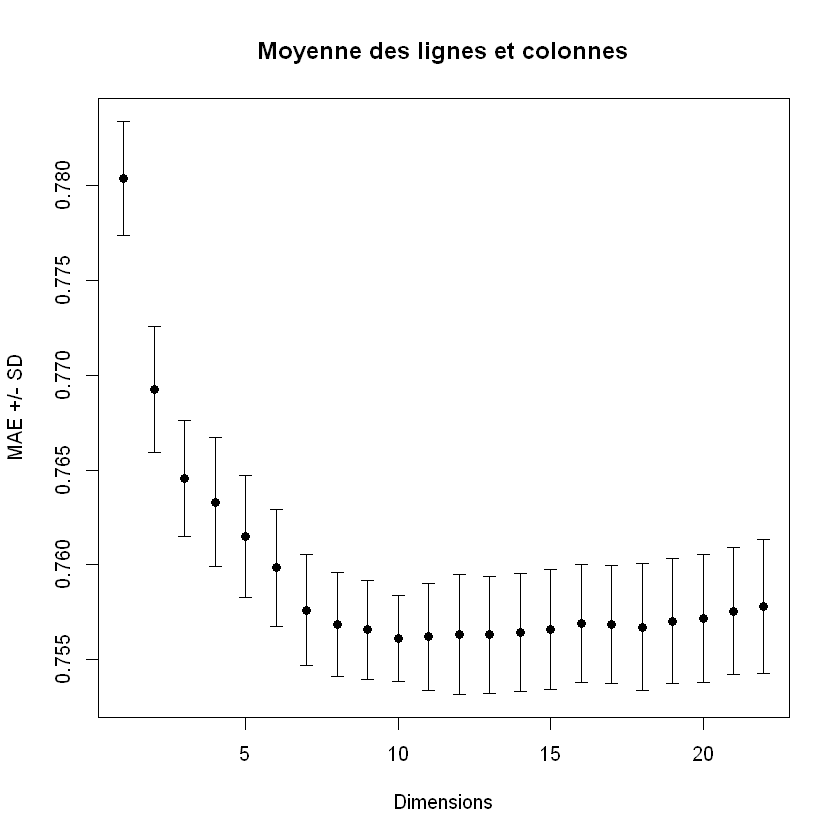

In [63]:
plot(x,avg,ylim=range(c(avg-sdev, avg+sdev)),pch=19, xlab="Dimensions", ylab="MAE +/- SD",
    main="Moyenne des lignes et colonnes"
)
# hack: we draw arrows but with very special "arrowheads"
arrows(x, avg-sdev, x, avg+sdev, length=0.05, angle=90, code=3)

In [64]:
mean(cv.b)

[1] 0.7949921

In [65]:
avg

[1] 0.7803628 0.7692556 0.7645615 0.7633096 0.7615050 0.7598421 0.7576222
 [8] 0.7568571 0.7565948 0.7561171 0.7562216 0.7563183 0.7563242 0.7564354
[15] 0.7565878 0.7569238 0.7568410 0.7567171 0.7570259 0.7571912 0.7575573
[22] 0.7578110

In [57]:
write.table(avg, file="out/total/mean.csv",sep="")